Code queries - Lalitha Raghavan

# Create a Bayesian model for price optimization 

### References - https://austinrochford.com/posts/2021-06-10-lego-pymc3.html

### Used a Half-Normal here - checked with Cauchy, not much of a difference in the results.

In [1]:
import pymc3 as pm
from pymc3 import  *
import theano
import theano.tensor as tt
print('Running on PyMC3 v{}'.format(pm.__version__))

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


Testing the Bayesian model on Roller+Roller LB, SiSiC, Rodental Plant

Filtered data and extracted only these values to a different excel sheet, created a new column based on the weight per kg based off selling price and total weight sold.

Can customize model based on additional filters to use same sheet - need to code for that (didn't bother)

In [3]:

df = pd.read_excel(r'C:\Users\L7927301\Documents\Projects\Global PCR Pricing\roller_pricing.xlsx', sheet_name='Complexity 1',usecols=['WGT net KG (from MD)', 'Unit Price'])
df.columns = ['Quantity', 'Price']
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

## Grouping the data to ensure that we capture total quantities sold for each individual price

df = df.groupby(['Price'])['Quantity'].sum().reset_index()
p0 = df['Price']
d0 = df['Quantity']

In [4]:
df.describe()

,Price,Quantity
count,42.000000,42.000000
mean,42.451198,5187.477905
std,6.052043,11658.087423
min,24.773394,19.812000
25%,36.875362,160.725000
50%,43.495980,1219.124500
75%,46.037103,4106.070000
max,53.966650,60223.800000


Normally price distribution is written as Q=aP^c (ref: https://www.dummies.com/education/economics/econometrics/econometrics-and-the-log-log-model/) where Q is the quantity sold, P is the price, c is the constant price elasticity (usually negative) and a is the function describing the relation between Q and P. We have not done any reparameterization (wiki this - not easy to understand but in a broad sense you are rewriting the equation to remove long tailedness, high correlations)

In [24]:

with pm.Model() as m:
    # priors
    log_b = pm.Normal('log_b', sd = 2.5)
    a = pm.Normal('a', sd = 5)

    log_d = log_b + a * np.log(p0)                    # demand model  Ref: https://blog.griddynamics.com/dynamic-pricing-algorithms/

    μ0 = pm.Deterministic('μ0',np.exp(log_d))

    qval = pm.Poisson('d0', μ0, observed = d0)    # likelihood

Now we extract values from the posterior using MCMC sampling method 

Markov Chain Monte Carlo provides an alternate approach to random sampling a high-dimensional probability distribution where the next sample is dependent upon the current sample. (Ref: https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/)

In [25]:
with m:
    trace = pm.sample(4000,tune=1000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\L7927301\Documents\Projects\Global PCR Pricing\bayesian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\L7927301\Documents\Projects\Global PCR Pricing\bayesian\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, log_b]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 371 seconds.
The acceptance probability does not match the target. It is 0.8919390850044668, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013193791621675, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_b,22.565,0.038,22.495,22.638,0.001,0.001,1370.0,1274.0,1.0
a,-3.801,0.011,-3.820,-3.781,0.000,0.000,1376.0,1310.0,1.0
μ0[0],31746.627,154.106,31461.988,32036.130,3.936,2.784,1545.0,1576.0,1.0
μ0[1],8725.761,19.866,8688.385,8762.721,0.308,0.218,4163.0,5024.0,1.0
μ0[2],8454.512,19.012,8419.750,8490.928,0.285,0.202,4454.0,5128.0,1.0
μ0[3],7661.419,16.717,7630.544,7693.158,0.222,0.157,5684.0,5199.0,1.0
μ0[4],7661.419,16.717,7630.544,7693.158,0.222,0.157,5684.0,5199.0,1.0
μ0[5],7621.856,16.611,7591.191,7653.458,0.219,0.155,5770.0,5217.0,1.0
μ0[6],7621.854,16.611,7591.189,7653.456,0.219,0.155,5770.0,5217.0,1.0
μ0[7],7621.852,16.611,7591.188,7653.455,0.219,0.155,5770.0,5217.0,1.0


we now plot the trace - columns on the left indicate similarties. If the shape of each independent variable does not overlap significantly, it means our sampling is wrong. In the below chart, it seems to overlap pretty well and the auto-correlation in the right hand columns also indicate that the sampling technique is ok to proceed with

C:\Users\L7927301\AppData\Local\Temp/ipykernel_17944/2777670638.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);


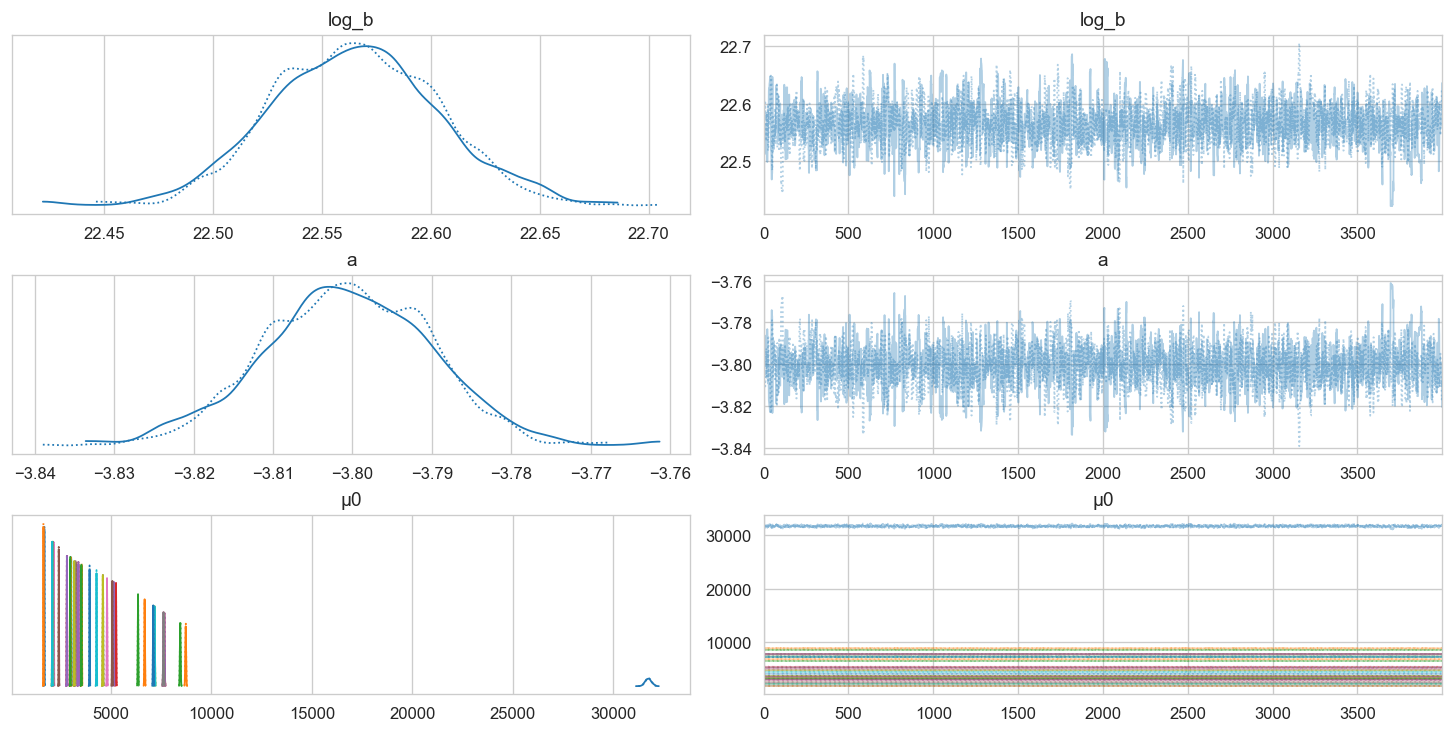

In [27]:
pm.traceplot(trace);

c:\Users\L7927301\Documents\Projects\Global PCR Pricing\bayesian\lib\site-packages\arviz\plots\plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


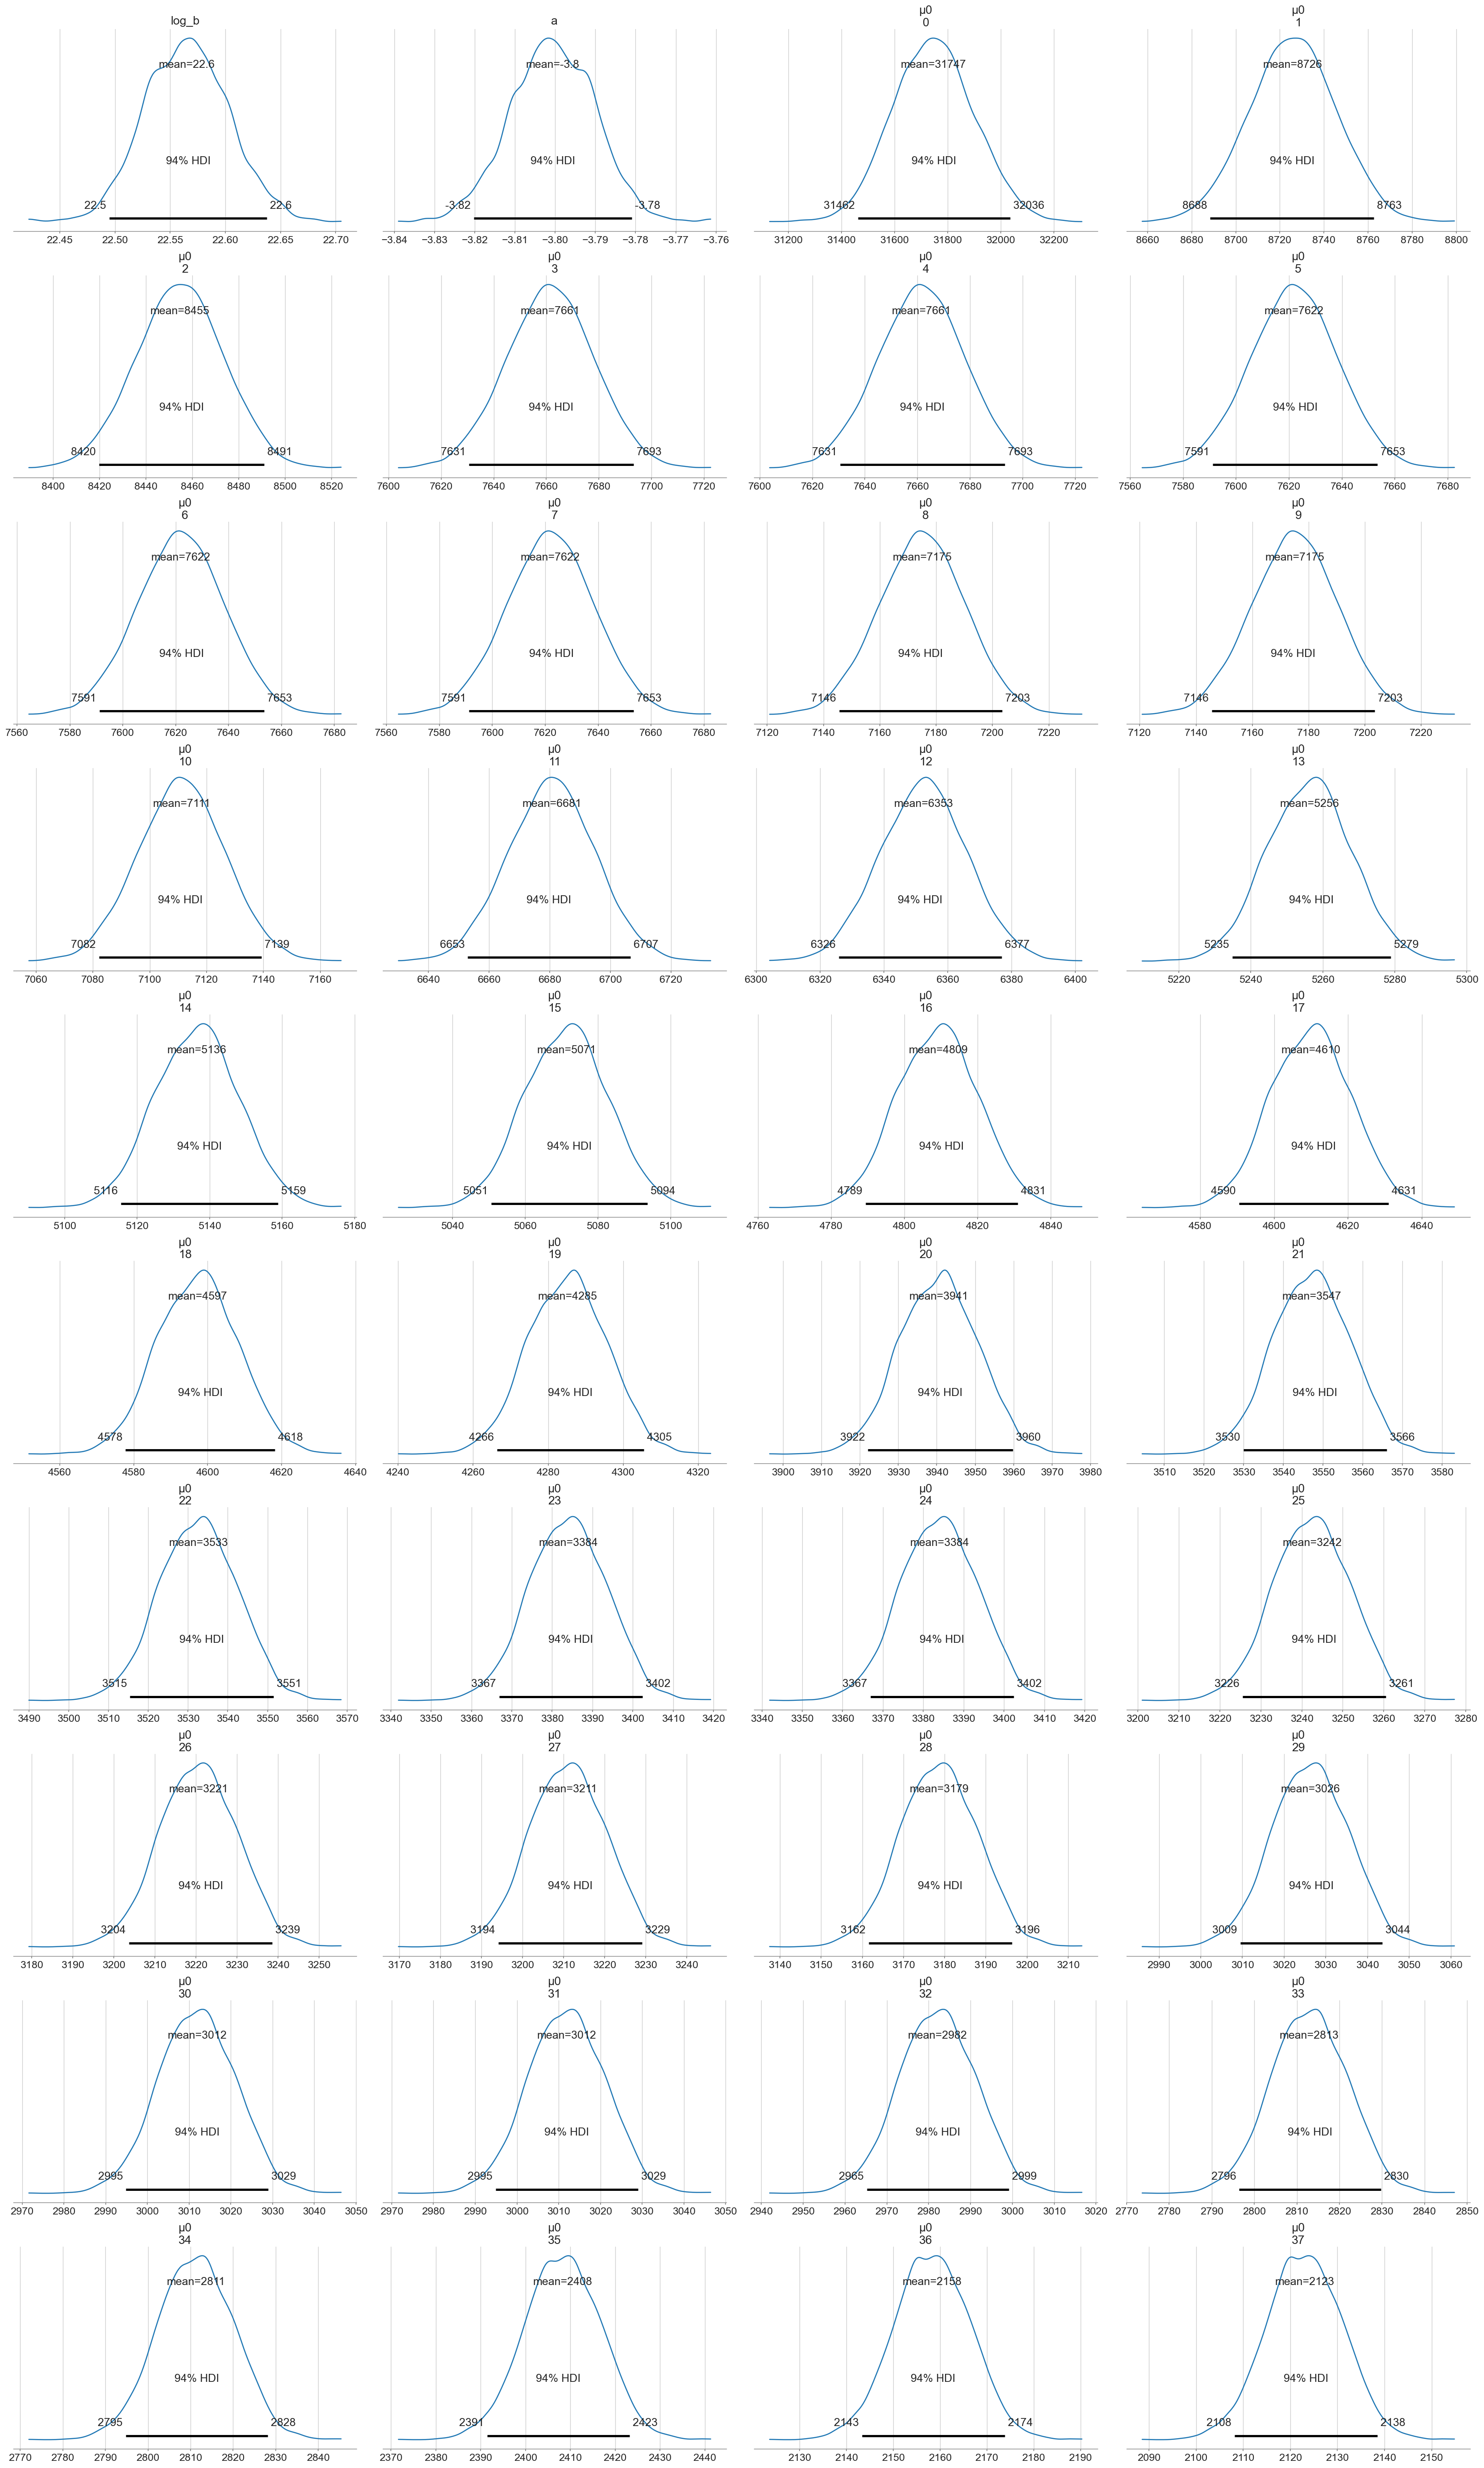

In [29]:
plot_posterior(trace, round_to=3)
plt.show()

### Plotting from the posterior threads

Each black line below is a sample we have derived from the posterior checks. The red dots represent actual data points. The points that lie outside of the black lines are probably outliers. We may choose more sampling to be sure (**  run checks for this and run a larger sampliing size)

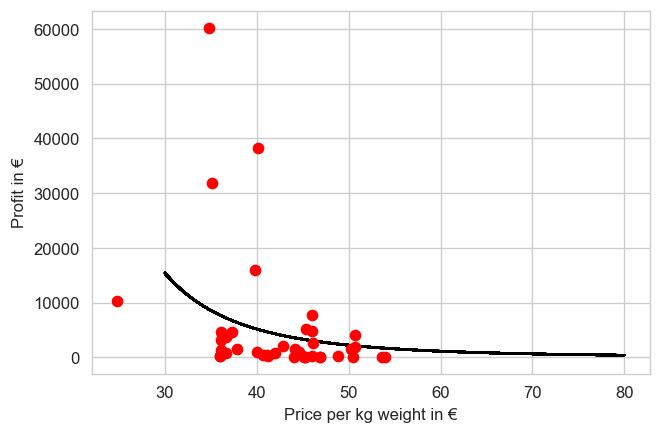

In [31]:
plt.rcParams['figure.dpi'] = 120
p = np.linspace(30,80)
d_means = np.exp(trace.log_b + trace.a * np.log(p).reshape(-1, 1))

plt.plot(p, d_means, c = 'k', alpha = 0.01)
plt.plot(p0, d0, 'o', c = 'r')
plt.xlabel("Price per kg weight in €")
plt.ylabel("Profit in €")
plt.show()

In [32]:
k = 32.38  # Expected cost price - how do we determine this? i took a random average value based on Fixed+Variable costs 
π = (p - k).reshape(-1,1) * d_means

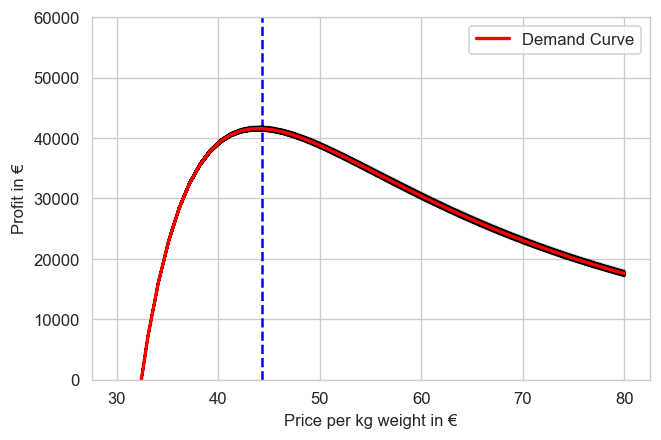

In [33]:
plt.rcParams['figure.dpi'] = 120
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(p,np.mean(π,1).T,c='red',lw=2,label="Demand Curve");
pmax = p[np.argmax(np.mean(π,1))]
plt.vlines(pmax,0,60000,colors='blue',linestyles='dashed')

plt.ylim(0,60000);
plt.xlabel("Price per kg weight in €")
plt.ylabel("Profit in €")

plt.legend();

In [34]:
pmax

44.285714285714285

In [35]:
b = np.mean(trace.a)  
p_opt_mean = k/(1+(1/b))  
p_opt_mean

43.94138773687259